#                        Applied Machine Learning (COMP9060)

## Project 2:
### Building a random forest regression model to predict the housing prices using Boston dataset

### Shanmugapriya Murugavel - R00195696

### Importing necessary libraries

In [182]:
import os
import time
import pydot
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import scorer
from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit, train_test_split
#from sklearn.cross_validation import train_test_split

%matplotlib inline

### Reading data and observing summary statistics

In [141]:
data = pd.read_csv(r'D://BostonHousingDataset.csv')

In [142]:
data.head(5) 
features = data.iloc[:, :-1].values
prices = data.iloc[:, 13].values
data.head()
print('The shape of our features is:', data.shape)
data.describe() # Descriptive statistics for each column

The shape of our features is: (489, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV
count,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,489.000000,4.890000e+02
mean,3.643587,11.134969,11.098855,0.057260,0.553973,6.240288,68.249080,3.838465,9.484663,407.474438,18.516564,355.858119,12.939632,4.543429e+05
std,8.731083,22.862476,6.820944,0.232576,0.116572,0.643650,28.185847,2.110297,8.675400,167.830601,2.111268,92.729118,7.081990,1.653403e+05
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.137000,1.000000,187.000000,12.600000,0.320000,1.980000,1.050000e+05
25%,0.081990,0.000000,5.190000,0.000000,0.449000,5.880000,44.400000,2.112100,4.000000,280.000000,17.400000,376.040000,7.370000,3.507000e+05
50%,0.245220,0.000000,9.690000,0.000000,0.538000,6.185000,76.700000,3.279700,5.000000,330.000000,19.100000,391.830000,11.690000,4.389000e+05
75%,3.673670,12.500000,18.100000,0.000000,0.624000,6.575000,93.900000,5.214600,24.000000,666.000000,20.200000,396.330000,17.120000,5.187000e+05
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.398000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,1.024800e+06


### Statistics of Label (Price)

In [143]:
# Minimum price of the data
minimum_price = np.min(prices)

# Maximum price of the data
maximum_price = np.max(prices)

# Mean price of the data
mean_price = np.mean(prices)

# Median price of the data
median_price = np.median(prices)

# Standard deviation of prices of the data
std_price = np.std(prices)

# Show the calculated statistics
print("Statistics for Boston housing dataset:\n")
print("Minimum price: ${:,.2f}".format(minimum_price))
print("Maximum price: ${:,.2f}".format(maximum_price))
print("Mean price: ${:,.2f}".format(mean_price))
print("Median price ${:,.2f}".format(median_price))
print("Standard deviation of prices: ${:,.2f}".format(std_price))

Statistics for Boston housing dataset:

Minimum price: $105,000.00
Maximum price: $1,024,800.00
Mean price: $454,342.94
Median price $438,900.00
Standard deviation of prices: $165,171.13


In [144]:
# Creating feature list for Decision tree vizualization
col_names = list(data.columns)
feature_list=col_names[0:13]
print(feature_list)

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'BLACK', 'LSTAT']


### Training and Testing Sets

In [179]:
# Splitting the data into training and testing sets
train_features, test_features, train_prices, test_prices = train_test_split(features, prices, test_size = 0.25, random_state = 30)

print("Training and testing split was successful.\n")
print('Training Features Shape:', train_features.shape)
print('Training Prices Shape:', train_prices.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Prices Shape:', test_prices.shape)

Training and testing split was successful.

Training Features Shape: (366, 13)
Training Prices Shape: (366,)
Testing Features Shape: (123, 13)
Testing Prices Shape: (123,)


In [181]:
# Check if split is actually correct
# We can see it's roughly 75% train and 25% train
# So we can proceed!
print(features.shape[0])
print(float(train_features.shape[0]) / float(features.shape[0]))
print(float(test_features.shape[0]) / float(features.shape[0]))

489
0.7484662576687117
0.25153374233128833


### Establishing a baseline model

In [146]:
# Baseline error: Error generated if we simply predicted the prices for all entries.
baseline_preds = test_features[:, 12]

# Display the average baseline error
baseline_errors = abs(baseline_preds - test_prices)
print('Average baseline error:', round(np.mean(baseline_errors), 2),'dollars.')

Average baseline error: 443992.0 dollars.


### Train the Model

In [147]:
# Instantiating model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 30)
# Train the model on training data
simple_model= rf.fit(train_features, train_prices);

### Making Predictions on the Test Set

In [148]:
# Making predictions on test data
base_predictions = simple_model.predict(test_features)
# Calculating absolute error
base_errors = abs(base_predictions - test_prices)

# Printing mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(base_errors), 2), 'dollars.')

Mean Absolute Error: 40784.63 dollars.


### Determining Performance Metrics

In [149]:
# Calculating mean absolute percentage error (MAPE)
mape = 100 * (base_errors / test_prices)

# Calculating and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 5), '%.')

Accuracy: 88.96971 %.


### Visualizing a Single Decision Tree

In [150]:
# Setting path
#os.environ["PATH"] += os.pathsep + r'C:\Users\Tanay\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'
#os.environ["PATH"] += os.pathsep + r'C:\Users\Tanay\Anaconda3\pkgs\graphviz-2.38.0-4\Library\bin\graphviz'

#Pulling out one tree from the forest
#tree = rf.estimators_[5]

#Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

#Using dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')

#Write graph to a png file
#graph.write_png('tree.png');

#print('The depth of this tree is:', tree.tree_.max_depth)


<img src="tree.png">

In [151]:
# Limiting the depth to 2 levels for better viz
#rf_small = RandomForestRegressor(n_estimators=1000, max_depth = 3, random_state=30)
#rf_small.fit(train_features, train_prices)

# Extracting small tree
#tree_small = rf_small.estimators_[5]

# Saving the tree as a png image
#export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)

#(graph, ) = pydot.graph_from_dot_file('small_tree.dot')

#graph.write_png('small_tree.png');

<img src="small_tree.png">

### Doing sample predictions

In [152]:
client_data = [[0.00632, 18, 2.31, 0, 0.538, 6.575, 65.2 ,4.09, 1, 296, 15.3, 396.9, 4.98],
               [0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 15, 0, 17],
               [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 22, 0, 32],
               [0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 12, 0, 3]]

In [153]:
# Base model predictions
for i, price in enumerate(simple_model.predict(client_data)):
    print ("Predicted selling price for Client {}'s home by using Random forest is: ${:,.2f}".format(i+1, price))

Predicted selling price for Client 1's home by using Random forest is: $579,799.50
Predicted selling price for Client 2's home by using Random forest is: $430,590.30
Predicted selling price for Client 3's home by using Random forest is: $384,898.50
Predicted selling price for Client 4's home by using Random forest is: $950,707.80


## Model Improvement

### Feature Reduction
Reducing the number of features to reduce runtime, without significantly reducing performance.


### Feature Importances

In [154]:
# Getting numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sorting feature importances in ascending order (most important)
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: LSTAT                Importance: 0.45
Variable: RM                   Importance: 0.35
Variable: CRIM                 Importance: 0.06
Variable: NOX                  Importance: 0.04
Variable: DIS                  Importance: 0.02
Variable: TAX                  Importance: 0.02
Variable: PTRATIO              Importance: 0.02
Variable: BLACK                Importance: 0.02
Variable: INDUS                Importance: 0.01
Variable: AGE                  Importance: 0.01
Variable: ZN                   Importance: 0.0
Variable: CHAS                 Importance: 0.0
Variable: RAD                  Importance: 0.0


### Visualize Feature Importances

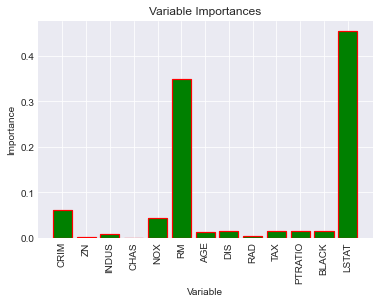

In [155]:
# Reset style 
# plt.style.use('ggplot')
# plt.style.use('seaborn-bright')
plt.style.use('seaborn-darkgrid')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'g', edgecolor = 'r', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

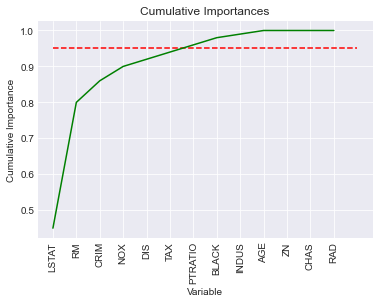

In [156]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Limit Number of Features

In [157]:
# Finding number of features for cumulative importance of 95%
# Adding 1 as Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 7


In [158]:
# Extracting the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:7]]
# Finding columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Creating training and testing sets with only important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (366, 7)
Important test features shape: (123, 7)


### Training on Important Features

In [159]:
# Training the model on only the important features
rf.fit(important_train_features, train_prices);

### Evaluate on Important features

In [160]:
# Make predictions on test data
predictions = rf.predict(important_test_features)

# Performance metrics
errors = abs(predictions - test_prices)

print('Average absolute error:', round(np.mean(errors), 4), 'dollars.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_prices)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 5), '%.')

Average absolute error: 40377.4171 dollars.
Accuracy: 88.97062 %.


As we can see Average Absolute error decreases by 394.352 dollars

### Comparing Trade-Offs

In [161]:
# Using only the 7 most important features (out of 13) results in increase in accuracy as well as decrease in run time (In my model).

# Use time library for run time evaluation
import time

# All features training and testing time
all_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf.fit(train_features, train_prices)
    all_features_predictions = rf.predict(test_features)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

All features total training and testing time: 5.48 seconds.


In [162]:
# Total training and testing time for reduced feature set
reduced_features_time = []

# Doing 10 iterations and taking average
for _ in range(10):
    start_time = time.time()
    rf.fit(important_train_features, train_prices)
    reduced_features_predictions = rf.predict(important_test_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

Reduced features total training and testing time: 4.19 seconds.


### Accuracy vs Run-Time

In [163]:
all_accuracy =  100 * (1- np.mean(abs(all_features_predictions - test_prices) / test_prices))
reduced_accuracy = 100 * (1- np.mean(abs(reduced_features_predictions - test_prices) / test_prices))

comparison = pd.DataFrame({'features': ['all (13)', 'reduced (7)'], 
                           'run_time': [round(all_features_time, 2), round(reduced_features_time, 5)],
                           'accuracy': [round(all_accuracy, 2), round(reduced_accuracy, 6)]})

comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all (13),88.97000,5.48000
1,reduced (7),88.97062,4.18583


In [164]:
relative_accuracy_increase = 100 * (all_accuracy - reduced_accuracy) / all_accuracy
print('Relative increase in accuracy:', round(relative_accuracy_increase, 10), '%.')

relative_runtime_decrease = 100 * (all_features_time - reduced_features_time) / all_features_time
print('Relative decrease in run time:', round(relative_runtime_decrease, 5), '%.')

Relative increase in accuracy: -0.0010193935 %.
Relative decrease in run time: 23.55231 %.


Thus this model is both accurate and fast.

## Hyper parameter Tuning

Examining the default Random Forest to determine parameters

In [165]:
rf = RandomForestRegressor(random_state = 30)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 30,
 'verbose': 0,
 'warm_start': False}


### Random Search with Cross Validation

In [166]:
# Random Hyperparameter Grid
# Creating a parameter grid to sample from during fitting
    
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)  

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [167]:
    # Random Search Training
    # Instantiating the random search and fitting it.
    # Using the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=30, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(train_features, train_prices)    
    rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

### Evaluating Random Search

In [168]:
# If random search yielded a better model, we compare the base model with the best random search model

# Evaluation Function
def evaluate(model, test_features, test_prices):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_prices)
    mape = 100 * np.mean(errors / test_prices)
    accuracy = 100 - mape
    print('Model Performance:')
    print('Average Error: {:0.3f} dollars.'.format(np.mean(errors)))
    print('Accuracy = {:0.10f}%.'.format(accuracy))    
    return accuracy

### Evaluating the Default (Base) Model

In [169]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 30)
base_model.fit(train_features, train_prices)
base_accuracy = evaluate(base_model, test_features, test_prices)

Model Performance:
Average Error: 40784.629 dollars.
Accuracy = 88.9697126042%.


### Evaluating the Best Random Search Model

In [170]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_prices)
print('Improvement of {:0.6f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Average Error: 39716.720 dollars.
Accuracy = 89.2055212806%.
Improvement of 0.265044%.


### Grid Search with Cross Validation
Performing grid search building on the result from the random search. And testing a range of hyperparameters around the best values returned by random search.

In [171]:
# Making another grid based on the best values provided by random search:

param_grid = {
    'bootstrap': [False],
    'max_depth': [110,None],
    'max_features': [2, 3],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [400]
}
# Creating a based model
rf = RandomForestRegressor()
# Instantiating the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [172]:
# Fitting the grid search to the data
grid_search.fit(train_features, train_prices)

# Fitting the model, display the best hyperparameters, and evaluate performance:
grid_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.9s finished


{'bootstrap': False,
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [173]:
# Evaluating the Best Model from Grid Search
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_prices)    
print('Improvement of {:0.5f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Model Performance:
Average Error: 39592.043 dollars.
Accuracy = 89.3024293077%.
Improvement of 0.37397%.


### Another Round of Grid Search

In [174]:
# Create the parameter grid based on the results of previous Grid search

param_grid = {
    'bootstrap': [False],
    'max_depth': [None],
    'max_features': [3],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'n_estimators': [400]
}
# Creating a based model
rf = RandomForestRegressor()
# Instantiating the grid search model
grid_search_ad = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search_ad.fit(train_features, train_prices)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': [3], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [400]},
             verbose=2)

In [175]:
grid_search_ad.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 400}

In [176]:
best_grid_ad= grid_search_ad.best_estimator_
grid_ad_accuracy=evaluate(best_grid_ad, test_features, test_prices)
  
print('Improvement of {:0.5f}%.'.format( 100 * (grid_ad_accuracy - grid_accuracy) / base_accuracy))

Model Performance:
Average Error: 40225.415 dollars.
Accuracy = 89.1097715418%.
Improvement of -0.21654%.


This time our performance slightly increased. Therefore, finalizing this model

### Final Model

In [177]:
print('Model Parameters:\n')
pprint(grid_search.get_params())
print('\n')
evaluate(grid_search_ad, test_features, test_prices)

Model Parameters:

{'cv': 3,
 'error_score': nan,
 'estimator': RandomForestRegressor(),
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': {'bootstrap': [False],
                'max_depth': [110, None],
                'max_features': [2, 3],
                'min_samples_leaf': [1],
                'min_samples_split': [2],
                'n_estimators': [400]},
 'pre_dispatch': '

89.10977154175511

### Training Visualizations

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished


Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   16.8s finished


KeyError: 'mean_train_score'

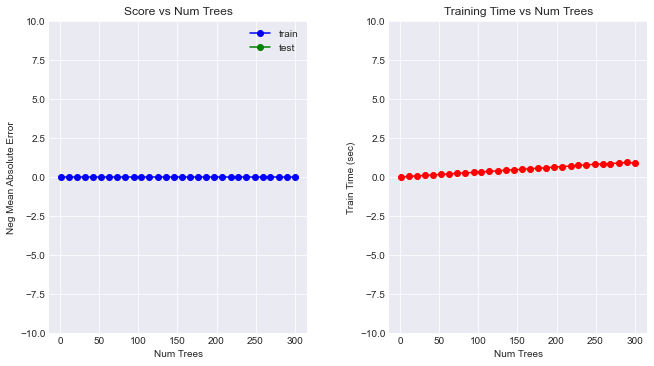

In [178]:
# Training Curves
plt.style.use('seaborn-darkgrid')

# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(best_grid_ad, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,return_train_score=True,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(train_features, train_prices);
tree_grid_search.cv_results_
#GridSearchCV(return_train_score=True)

def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 10)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = -10.0, ymax = 10.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)        
    plt.tight_layout(pad = 4)
        
plot_results(tree_grid_search)

# Number of Features at Each Split
# Define a grid over only the maximum number of features
feature_grid = {'max_features': list(range(1, train_features.shape[1] + 1))}

# Creating the grid search and fitting on the training data
feature_grid_search = GridSearchCV(best_grid, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'neg_mean_absolute_error')
feature_grid_search.fit(train_features, train_prices);

plot_results(feature_grid_search, param='max_features', name = 'Max Features')

In [ ]:
# Tuned model predictions
for i, price in enumerate(grid_search_ad.predict(client_data)):
    print ("Predicted selling price for Client {}'s home by using Random forest is: ${:,.2f}".format(i+1, price))

In [ ]:
# Save the model to disk
filename = r'C:\Users\Desktop\Priya\RandomForest.sav'
  
pickle.dump(grid_search_ad, open(filename, 'wb'))
 
# loading the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(test_features, test_prices)
print(result)

